In [1]:
import sys
import numpy as np
import pandas as pd 
from skmultiflow.data import DataStream, MultilabelGenerator, ConceptDriftStream
from skmultiflow.meta import ClassifierChain
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from skmultiflow.metrics import hamming_score
from sklearn.metrics import accuracy_score, f1_score
from ld3 import LD3
from skmultilearn.dataset import load_from_arff
from sklearn.preprocessing import MultiLabelBinarizer
from skmultiflow.drift_detection import ADWIN, EDDM, KSWIN, HDDM_W, HDDM_A, DDM, PageHinkley
import util
import warnings
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from river.metrics import ExampleF1
from scipy.stats import truncnorm

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)

In [9]:
'''n_features = 100
n_targets = 20
s1 = MultilabelGenerator(n_samples=3000, n_features=n_features, n_targets=n_targets, n_labels=1, random_state=0)
s2 = MultilabelGenerator(n_samples=3009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=250)
stream = ConceptDriftStream(stream=s1, drift_stream=s2, position=2000, width=1, random_state=0)
sample_size=5000'''

X, y = load_from_arff('./datasets/{}'.format('20NG.arff'), label_count=20)
X = X.toarray()
y = y.toarray().astype(np.int8)
sample_size = len(X)
n_features = X.shape[1]

if len(np.unique(y)) > 2:
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(y)

n_targets = y.shape[1]
stream = DataStream(data = X, y=y, n_targets=n_targets)

  0%|          | 0/19300 [00:00<?, ?it/s]

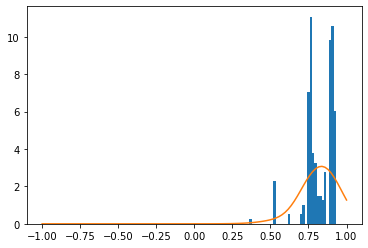

Correlation:  0.3610905185610317
Score:  0.0514279668723988
Drift@ 5300
[ 9,1,19,18,8,2,13,4,3,7,15,16,6,5,12,11,0,14,10,17 ] 	[ 19,18,3,1,7,6,2,14,4,11,9,8,5,10,15,13,12,16,17,0 ]


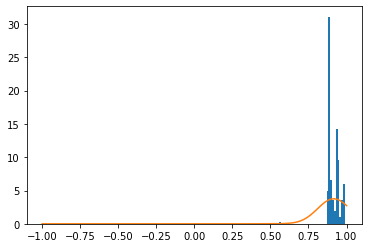

Correlation:  0.5562343778321716
Score:  0.02561067228536596
Drift@ 6362
[ 19,13,1,3,18,6,2,0,8,5,7,4,16,11,15,14,9,10,12,17 ] 	[ 19,18,1,6,2,9,3,7,5,4,12,8,11,10,15,16,13,14,17,0 ]


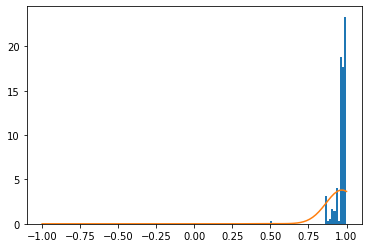

Correlation:  0.49428600023438085
Score:  0.01617732349604982
Drift@ 18034
[ 19,17,18,3,1,2,5,14,8,0,4,6,7,9,15,10,11,12,13,16 ] 	[ 19,18,3,1,2,0,4,5,8,6,7,14,9,10,16,11,12,13,15,17 ]

0.547461139896373
0.9665492227979275
0.6028877374784111
0.6577608142493638
0.6580187262078417



In [11]:
from ld3_ import LD3
detector = LD3(window_size=250, correlation_thresh=0.06, bandwith=0.1) #20NG-1-5   Synthetic-0.51    tmc 0.4-4/5     imbd 1-4     ohsumed 0.5
clf = ClassifierChain(PassiveAggressiveClassifier(random_state=0))
pre_sample = [np.zeros(n_features), np.zeros(n_features)]
pre_label = [np.ones(n_targets), np.zeros(n_targets)]
clf.fit(np.array(pre_sample), np.array(pre_label))

stream.restart()
max_samples = sample_size
y_true = []
y_pred = []
pretrain_X = []
pretrain_y = []
correlation_list = []
p_bar = tqdm(total=max_samples)
n_samples = 0
drift, warning = False, False
correlation = 0
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    '''if n_samples % 100 == 0 and n_samples >500:
        print(detector._average_correlation)'''
            
    '''if n_samples >= 1990 and n_samples <= 2050:
        print('Correlation @', n_samples, ': ', score, correlation)
        #print(detector._average_correlation)
        #r1, r2 = detector._ranks
        #print('[',','.join(list(map(str,r1))), ']', '\t[', ','.join(list(map(str,r2))), ']')'''
    if drift:
        print('Drift@', n_samples)
        r1, r2 = detector._ranks
        print('[',','.join(list(map(str,r1))), ']', '\t[', ','.join(list(map(str,r2))), ']')
        clf.reset()
        clf.fit(np.array(pre_sample), np.array(pre_label))

    pred = clf.predict(X)
    #clf.partial_fit(X, np.array([y]))
    clf.partial_fit(X, y)
    drift, warning, correlation, score = detector.update(pred.astype(np.int32))
    if correlation > 0:
        correlation_list.append(correlation)
    #detector.add_element(np.all(pred.flatten() == y))

    #y_true.append(y)
    y_true.extend(y)
    y_pred.extend(pred)

    p_bar.update(1)
    n_samples += 1
p_bar.close()
stream.restart()

print()
print(accuracy_score(np.array(y_true), np.array(y_pred)))
print(hamming_score(np.array(y_true), np.array(y_pred)))
print(f1_score(np.array(y_true), np.array(y_pred), average='samples'))
print(f1_score(np.array(y_true), np.array(y_pred), average='micro'))
print(f1_score(np.array(y_true), np.array(y_pred), average='macro'))
print()

In [10]:
detectors = [ADWIN(), EDDM(), DDM()]
for detector in detectors:
    #detector = EDDM()#LD3(k=1, window_size=500)
    clf = ClassifierChain(PassiveAggressiveClassifier(random_state=0))
    pre_sample = [np.zeros(n_features), np.zeros(n_features)]
    pre_label = [np.ones(n_targets), np.zeros(n_targets)]
    clf.fit(np.array(pre_sample), np.array(pre_label))


    max_samples = sample_size
    y_true = []
    y_pred = []
    pretrain_X = []
    pretrain_y = []
    p_bar = tqdm(total=max_samples)
    n_samples = 0

    while n_samples < max_samples and stream.has_more_samples():
        X, y = stream.next_sample()

        if detector.detected_change():
            print('Drift@', n_samples)
            detector.reset()
            clf.reset()
            clf.fit(np.array(pre_sample), np.array(pre_label))

        pred = clf.predict(X)
        #clf.partial_fit(X, np.array([y]))
        clf.partial_fit(X, y)
        #detector.add_element(pred.astype(np.int32))
        #detector.add_element(np.all(pred.flatten() == y))
        detector.add_element((pred.astype(np.int32).flatten().tolist())==(y.astype(np.int32).flatten().tolist()))

        #y_true.append(y)
        y_true.extend(y)
        y_pred.extend(pred)

        p_bar.update(1)
        n_samples += 1
    
    print(accuracy_score(np.array(y_true), np.array(y_pred)))
    print(hamming_score(np.array(y_true), np.array(y_pred)))
    print(f1_score(np.array(y_true), np.array(y_pred), average='samples'))
    print(f1_score(np.array(y_true), np.array(y_pred), average='micro'))
    print(f1_score(np.array(y_true), np.array(y_pred), average='macro'))
    print()

    stream.restart()
    0.2346
0.9034700000000001
0.289334758912585
0.3533194881757889
0.3326566201173057

  0%|          | 0/19300 [00:00<?, ?it/s]

Drift@ 1791
Drift@ 2015
Drift@ 2527
Drift@ 3103
Drift@ 3711
Drift@ 4895
Drift@ 5343
Drift@ 5599
Drift@ 6111
Drift@ 6655
Drift@ 7167
Drift@ 7743
Drift@ 8319
Drift@ 9215
Drift@ 9983
Drift@ 11135
Drift@ 11903
Drift@ 12351
Drift@ 12863
Drift@ 13119
Drift@ 13983
Drift@ 14463
Drift@ 14847
Drift@ 15359
Drift@ 16031
Drift@ 16895
Drift@ 17343
Drift@ 18207
Drift@ 18591
Drift@ 19199
0.35590673575129533
0.9508056994818652
0.3881794643073818
0.4611368086495076
0.45567112871572923



  0%|          | 0/19300 [00:00<?, ?it/s]

Drift@ 87
Drift@ 215
Drift@ 485
Drift@ 716
Drift@ 913
Drift@ 1132
Drift@ 1340
Drift@ 1569
Drift@ 1831
Drift@ 1974
Drift@ 2012
Drift@ 2052
Drift@ 2121
Drift@ 2176
Drift@ 2353
Drift@ 2562
Drift@ 2742
Drift@ 2981
Drift@ 3210
Drift@ 3402
Drift@ 3595
Drift@ 3765
Drift@ 3929
Drift@ 4109
Drift@ 4296
Drift@ 4562
Drift@ 4802
Drift@ 5041
Drift@ 5250
Drift@ 5446
Drift@ 5541
Drift@ 5728
Drift@ 5902
Drift@ 6074
Drift@ 6241
Drift@ 6478
Drift@ 6637
Drift@ 6826
Drift@ 7012
Drift@ 7135
Drift@ 7306
Drift@ 7496
Drift@ 7712
Drift@ 7916
Drift@ 8020
Drift@ 8233
Drift@ 8466
Drift@ 8672
Drift@ 8901
Drift@ 9138
Drift@ 9381
Drift@ 9629
Drift@ 9830
Drift@ 9949
Drift@ 10112
Drift@ 10311
Drift@ 10555
Drift@ 10746
Drift@ 10992
Drift@ 11245
Drift@ 11476
Drift@ 11679
Drift@ 11847
Drift@ 12093
Drift@ 12289
Drift@ 12503
Drift@ 12704
Drift@ 12909
Drift@ 12993
Drift@ 13239
Drift@ 13451
Drift@ 13710
Drift@ 13954
Drift@ 14189
Drift@ 14438
Drift@ 14559
Drift@ 14704
Drift@ 14844
Drift@ 15040
Drift@ 15225
Drift@ 15367
Drift@ 

  0%|          | 0/19300 [00:00<?, ?it/s]

Drift@ 35
Drift@ 98
Drift@ 238
Drift@ 511
Drift@ 575
Drift@ 610
Drift@ 668
Drift@ 709
Drift@ 783
Drift@ 1067
Drift@ 1226
Drift@ 1511
Drift@ 1585
Drift@ 1694
Drift@ 1836
Drift@ 1877
Drift@ 1927
Drift@ 1963
Drift@ 3863
Drift@ 3896
Drift@ 4110
Drift@ 4230
Drift@ 4461
Drift@ 4588
Drift@ 4620
Drift@ 4853
Drift@ 4895
Drift@ 5020
Drift@ 5059
Drift@ 5139
Drift@ 5267
Drift@ 5426
Drift@ 5476
Drift@ 5929
Drift@ 6149
Drift@ 6320
Drift@ 6414
Drift@ 6478
Drift@ 6553
Drift@ 6599
Drift@ 6772
Drift@ 6942
Drift@ 7003
Drift@ 7511
Drift@ 7610
Drift@ 7777
Drift@ 7816
Drift@ 7857
Drift@ 7984
Drift@ 8569
Drift@ 8623
Drift@ 8832
Drift@ 9002
Drift@ 9252
Drift@ 9326
Drift@ 9361
Drift@ 9493
Drift@ 9641
Drift@ 9673
Drift@ 9756
Drift@ 9793
Drift@ 9878
Drift@ 9931
Drift@ 10797
Drift@ 10860
Drift@ 10973
Drift@ 11052
Drift@ 11084
Drift@ 11203
Drift@ 11252
Drift@ 11287
Drift@ 11325
Drift@ 11378
Drift@ 11421
Drift@ 11460
Drift@ 11524
Drift@ 11562
Drift@ 11596
Drift@ 11640
Drift@ 11673
Drift@ 11870
Drift@ 12145
Drift@ 1

0.3326566201173057

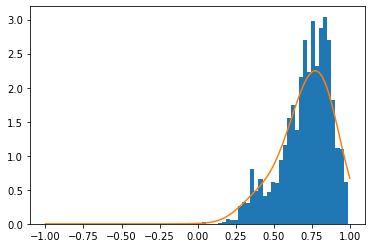

In [4]:
from sklearn.neighbors import KernelDensity
model = KernelDensity(bandwidth=1e-1, kernel='gaussian')
sample = np.array(correlation_list).reshape((len(correlation_list), 1))
model.fit(sample)
# sample probabilities for a range of outcomes
values = np.asarray([value for value in np.linspace(-1,1,100)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = np.exp(probabilities)
# plot the histogram and pdf
plt.hist(sample, bins=36, density=True)
plt.plot(values[:], probabilities)
plt.show()

In [ ]:
print(accuracy_score(np.array(y_true), np.array(y_pred)))
print(hamming_score(np.array(y_true), np.array(y_pred)))
print(f1_score(np.array(y_true), np.array(y_pred), average='samples'))
print(f1_score(np.array(y_true), np.array(y_pred), average='micro'))

In [10]:
a = np.array([1, 19, 3, 8, 5, 18, 4, 2, 0, 13, 11, 7, 17, 6, 9, 10, 12, 14, 15, 16])
b = np.array([19, 1, 2, 7, 3, 5, 18, 17, 13, 4, 8, 11, 0, 10, 6, 12, 9, 14, 15, 16]) 

c = np.array([19, 1, 2, 17, 10, 18, 7, 8, 3, 12, 4, 6, 5, 13, 11, 9, 14, 15, 0, 16])
d = np.array([19, 2, 1, 8, 18, 5, 17, 3, 13, 12, 4, 6, 7, 10, 11, 9, 14, 15, 16, 0]) 

x = np.array([ 1,8,19,5,13,0,17,2,18,11,3,6,9,10,12,4,7,14,15,16 ])
y = np.array([ 19,2,1,8,18,10,12,5,3,4,7,6,11,9,13,17,14,0,15,16 ])

e = np.array([ 8,19,17,1,3,5,0,9,18,2,4,6,11,7,13,12,10,14,15,16 ])
f = np.array([ 19,1,2,8,7,18,5,3,4,13,11,10,17,0,6,12,9,14,15,16 ])

In [3]:
argx = (np.argsort(a)).astype(np.float)#np.arange(1,21,1).astype(np.float)
argy = (np.argsort(b)).astype(np.float)#np.flip(np.arange(1,21,1)).astype(np.float) 
maxx = np.arange(1,21,1).astype(np.float)
maxy = np.flip(np.arange(1,21,1)).astype(np.float) 

'''for i in range(20):
    argx[i] *= 1/(argx[i]+1)
    argy[i] *= 1/(argy[i]+1)
    maxx[i] *= 1/(maxx[i]+1)
    maxy[i] *= 1/(maxy[i]+1)'''



'for i in range(20):\n    argx[i] *= 1/(argx[i]+1)\n    argy[i] *= 1/(argy[i]+1)\n    maxx[i] *= 1/(maxx[i]+1)\n    maxy[i] *= 1/(maxy[i]+1)'

In [9]:
print(argx)
print(argy)

[ 8.  0.  7.  2.  6.  4. 13. 11.  3. 14. 15. 10. 16.  9. 17. 18. 19. 12.
  5.  1.]
[12.  1.  2.  4.  9.  5. 14.  3. 10. 16. 13. 11. 15.  8. 17. 18. 19.  7.
  6.  0.]


In [6]:
def WS(rx, ry):
    sum_ = 0
    ranks_x = np.argsort(rx)
    ranks_y = np.argsort(ry)
    for i in range(len(rx)):
        sum_ += (1/(2**(ranks_x[i]))) * ((np.abs(ranks_x[i] - ranks_y[i]))/(np.max([np.abs(1-ranks_x[i]), np.abs(len(rx) - ranks_x[i])])))
    return 1 - sum_

In [14]:
WS(e,f)

0.6403404417406884

In [9]:
a = [1,2,3,4,5]
b = [5,4,3,2,1]
WS(a, b)

-0.2583333333333333

In [11]:
from scipy.stats import kendalltau, spearmanr
spearmanr(x[:5],y[:5])

SpearmanrResult(correlation=-0.7, pvalue=0.1881204043741873)

In [12]:
from scipy.spatial.distance import correlation
correlation(argx,argy)

0.15639097744360897

In [13]:
def dist(x, y, w):
    sum_ = 0
    for i in range(len(x)):
        abs_ = np.abs(x[i] - y[i])
        add =  abs_*w[i] if abs_ > 1 else 0
        sum_ += add
    return sum_
        

In [14]:
from scipy.spatial import distance
((dist(argx, argy, w=1/((3)**(argy*argy))) / np.sqrt(len(argx))) + (dist(argx, argy, w=1/((3)**(argx*argx))) / np.sqrt(len(argx)))) / 2 #/ 0.05617535148406078

0.00974723033648846

In [15]:
def rank_correlation(x, y, dist=distance.correlation):
        c = np.array([dist(x[i], y[i]) * (1/((y[i]))) for i in range(len(x))]).sum()
        return c
rank_correlation(argx, argy)

nan

In [16]:
1/argy

array([0.0833, 1.    , 0.5   , 0.25  , 0.1111, 0.2   , 0.0714, 0.3333,
       0.1   , 0.0625, 0.0769, 0.0909, 0.0667, 0.125 , 0.0588, 0.0556,
       0.0526, 0.1429, 0.1667,    inf])

In [17]:
from scipy.spatial import distance
dist = distance.cityblock # * 1/((argy[i])**2)
s = np.array([dist(argx[i], argy[i]) * 1/((argy[i])**2) for i in range(20)]).sum()

'''for i in range(20):
    s += dist(argx[i], argy[i]) * 1/((argy[i])**2)'''

smax = 0
for i in range(20):
    smax += dist(argx[i], argx[i]) * 1/((argy[i])**2)

print(s)

inf


In [18]:
0.5429113076754074
55.77
weigher = lambda r: 1/((1+r)**2)
print(weightedtau(a,b,rank=True, additive=False, weigher=weigher))
print(weightedtau(c,d,rank=True, additive=False, weigher=weigher))
print(weightedtau(x,y,rank=True, additive=False, weigher=weigher))

WeightedTauResult(correlation=-0.6713827328914972, pvalue=nan)
WeightedTauResult(correlation=0.3524122261236008, pvalue=nan)
WeightedTauResult(correlation=-0.7990832874910562, pvalue=nan)


In [19]:
print(np.where(a==b)[0])
print(np.where(c==d)[0])
print(np.where(x==y)[0])

[17 18 19]
[ 1 10]
[11 18 19]


In [20]:
weigher = lambda r: 1/((r+1))
print(weightedtau(np.argsort(a),np.argsort(b),rank=False, additive=False, weigher=weigher))
print(weightedtau(np.argsort(c),np.argsort(d),rank=False, additive=False, weigher=weigher))
print(weightedtau(np.argsort(x),np.argsort(y),rank=False, additive=False, weigher=weigher))

WeightedTauResult(correlation=0.6962121412338664, pvalue=nan)
WeightedTauResult(correlation=0.07118840640971633, pvalue=nan)
WeightedTauResult(correlation=0.18079986971236403, pvalue=nan)
